In [1]:
import pyspark
import pyspark.sql.functions as func
# ('spark.executor.cores', '4'), ('spark.cores.max', '4'),
conf1 = pyspark.SparkConf().setAll([('spark.executor.memory', '32g'), ('spark.driver.memory','32g'),('spark.driver.maxResultSize','4g')])

spark = pyspark.sql.SparkSession.builder \
    .appName("SparkML") \
    .config(conf=conf1) \
    .getOrCreate()
sc = spark.sparkContext
#sqlContext = pyspark.sql.SQLContext(sc)

ModuleNotFoundError: No module named 'pyspark'

In [3]:
sc.getConf().getAll()

[('spark.executor.memory', '32g'),
 ('spark.driver.memory', '32g'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1515232883863'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '44895'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '192.168.0.206'),
 ('spark.app.name', 'SparkML'),
 ('spark.driver.maxResultSize', '4g')]

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, Tokenizer
from pyspark.ml.feature import Word2Vec, NGram
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import re
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when

In [5]:
rdd = sc.textFile("Posts.txt")
rdd.take(1)

['Id\tPostTypeId\tAcceptedAnswerId\tCreationDate\tScore\tViewCount\tBody\tOwnerUserId\tLastEditorUserId\tLastEditDate\tLastActivityDate\tTitle\tTags\tAnswerCount\tCommentCount']

In [5]:
rdd.count()

12840

In [6]:
# przygotowuje listę znaczników lokalnie aby nie wywoływac przetwarzania rozproszonego wewnatrz RDD
# (każdy z komputerów odpytałby wszystkie komputery)

dane_lok = []
with open('Posts.txt') as posty:
    for line in posty:
        #print(i, line.split('\t'))
        dane_lok.append(line.split('\t')[6])
        
lista_znacznikow = list(map(lambda linia : re.findall('[<][\/]?[a-zA-Z0-9 "=,.\-\/]+[>]',linia), dane_lok))
zbior_znacznikow = set()
for item in lista_znacznikow:
    for it in item:
        zbior_znacznikow.add(it)
        
zbior_znacznikow

{'</A>',
 '</B>',
 '</a>',
 '</b>',
 '</blockquote>',
 '</code>',
 '</del>',
 '</em>',
 '</h1>',
 '</h2>',
 '</h3>',
 '</i>',
 '</kbd>',
 '</li>',
 '</ol>',
 '</p>',
 '</pre>',
 '</s>',
 '</strike>',
 '</strong>',
 '</sub>',
 '</sup>',
 '</ul>',
 '<B>',
 '<BR>',
 '<Br/>',
 '<a href="//commons.wikimedia.org/wiki/" rel="nofollow noreferrer">',
 '<a href="//en.wikipedia.org/wiki/Light-year" rel="nofollow">',
 '<a href="//en.wikipedia.org/wiki/Moon">',
 '<a href="//en.wikipedia.org/wiki/Selenography">',
 '<a href="//hsm.stackexchange.com/q/5103">',
 '<b>',
 '<blockquote>',
 '<br />',
 '<br/>',
 '<br>',
 '<code>',
 '<del>',
 '<em>',
 '<h1>',
 '<h2>',
 '<h3>',
 '<hr />',
 '<hr>',
 '<i>',
 '<kbd>',
 '<li>',
 '<ol start="2">',
 '<ol start="3">',
 '<ol start="4">',
 '<ol start="5">',
 '<ol start="6">',
 '<ol start="7">',
 '<ol start="9">',
 '<ol>',
 '<p>',
 '<pre>',
 '<s>',
 '<strike>',
 '<strong>',
 '<sub>',
 '<sup>',
 '<ul>'}

In [7]:
stemmer = SnowballStemmer("english")
# funkcja czyszcząca tekst
def oczysc_tresc(linia):
    #usuwam znaczniki HTML - mogę tak zrobić ponieważ znaczniki nie są podzbiorem żadnego słowa
    for znacznik in zbior_znacznikow:
        linia = linia.replace(znacznik,'')
    # znaki interpunkcyjne usuwam po usunięciu znaczników aby nie usunac znaków < > za wcześnie
    linia = linia.translate(str.maketrans("", "", string.punctuation))
    # usuwam stopwords
    filtrowane = [slowo for slowo in linia.split(' ') if slowo not in stopwords.words('english')]
    # zamieniam słowa na ich bazową formę
    rdzen = [stemmer.stem(slowo) for slowo in filtrowane]
    return " ".join(rdzen)

In [8]:
# Wybieram tylko kolumne Body - tylko wiersze będące pytaniami - przy okazji pozbywam sie pierwszego wiersza
# oczyszczam dane ze znaczników html
# wybieram Post type Id= 1 - to znaczy pytania - odpowiedzi mnie nie interesja
tresc2 = rdd. \
    map(lambda x: x.split("\t")). \
    filter(lambda x : x[1] == '1')

tresc2.take(3)

[['1',
  '1',
  '879',
  '2013-09-24T18:51:54.593',
  '28',
  '700',
  '<p>Suppose I would like to calculate the inclination of a satellite from the <strong>ecliptic</strong>. Would it be possible to do this with an amateur telescope? How would I go about doing so?</p><hr><p>Note: A good answer should tell what kind of telescope an amateur would need, what measurements they would need to make, then what calculations they would have to perform to get the inclination (or the "instantaneous angular measurement from the ecliptic at the time of measurement").</p>',
  '6',
  '6',
  '2013-11-01T11:23:02.907',
  '2014-02-03T16:49:55.200',
  'How do I calculate the inclination of an object with an amateur telescope?',
  '<inclination><amateur-observing>',
  '2',
  '0'],
 ['2',
  '1',
  '45',
  '2013-09-24T18:53:25.647',
  '15',
  '160',
  '<p>How are exoplanetary atmosphere compositional spectra distinguished from those of the parent star(s), from the composition of the planetary surface or any

In [9]:
tresc2.count()

5019

In [10]:
tresc = tresc2.map(lambda y : (oczysc_tresc(y[6].lower()),y[12].lower().replace('><', ',').replace('<','').replace('>','').split(',')))

tresc.take(2)

[('suppos would like calcul inclin satellit eclipt would possibl amateur telescop would go sonot good answer tell kind telescop amateur would need measur would need make calcul would perform get inclin instantan angular measur eclipt time measur',
  ['inclination', 'amateur-observing']),
 ('exoplanetari atmospher composit spectra distinguish parent star composit planetari surfac factor  actual possibl determin atmospher composit precis use methodar specif exampl analysi perform exoplanet',
  ['exoplanet', 'atmosphere'])]

In [12]:
#tresc_po_tagch = tresc.flatMap(lambda x: [(w, x[0]) for w in x[1]])
tresc_po_tagch = tresc.map(lambda x: (x[1][0], x[0]))
tresc_po_tagch.take(2)

[('inclination',
  'suppos would like calcul inclin satellit eclipt would possibl amateur telescop would go sonot good answer tell kind telescop amateur would need measur would need make calcul would perform get inclin instantan angular measur eclipt time measur'),
 ('exoplanet',
  'exoplanetari atmospher composit spectra distinguish parent star composit planetari surfac factor  actual possibl determin atmospher composit precis use methodar specif exampl analysi perform exoplanet')]

In [13]:
tresc_po_tagch.count()

5019

In [14]:
# oczyszczam dane i przygotowuje je do zasilenia Pipeline
def row_from_rdd(line):
    d = dict()
    d['Tag'] = line[0];
    d['Body'] = line[1];
    return pyspark.Row(**d)

In [15]:
rows = tresc_po_tagch \
    .map(lambda line: row_from_rdd(line)) 
    
# dzielę zbiór na zbiór testowy i treningowy    
#train=sc.parallelize(rows.(5000))

In [16]:
rows.take(1)

[Row(Body='suppos would like calcul inclin satellit eclipt would possibl amateur telescop would go sonot good answer tell kind telescop amateur would need measur would need make calcul would perform get inclin instantan angular measur eclipt time measur', Tag='inclination')]

In [17]:
df = spark.createDataFrame(rows)
df.printSchema()
df.show()

root
 |-- Body: string (nullable = true)
 |-- Tag: string (nullable = true)

+--------------------+------------------+
|                Body|               Tag|
+--------------------+------------------+
|suppos would like...|       inclination|
|exoplanetari atmo...|         exoplanet|
|easili resolv bin...| amateur-observing|
|sunspot one appea...|           the-sun|
|ive heard light c...|        black-hole|
|equatori coordin ...|        coordinate|
|mani movi popular...|general-relativity|
|venus realli inho...|         exoplanet|
|ever see side moo...|          the-moon|
|black hole much g...|        black-hole|
|accord hrefhttpso...|             venus|
|refer hrefhttpsas...|        black-hole|
|understand mass b...|        black-hole|
|navig possibl max...|          the-moon|
|planet uranus ano...|          rotation|
|assum object move...|             orbit|
|process star unde...|              star|
|museum lviv saw p...|              star|
|given exoplanet p...|         exoplanet|

In [18]:
# wybór tagów dla których zbuduję model - powody wydajnosciowe domowego komputera
# tworzymy tymczasowy widok do zapytania SQL

df.createTempView('forfun')
spark.sql("""
SELECT Tag, count(*) as il FROM forfun 
GROUP BY Tag
ORDER BY il desc
""").show()


+-----------------+---+
|              Tag| il|
+-----------------+---+
|             star|455|
|            orbit|269|
|          the-sun|244|
|         the-moon|243|
|       black-hole|230|
|           planet|210|
|           galaxy|206|
|        telescope|193|
|          gravity|190|
|     solar-system|186|
|         universe|139|
|        exoplanet|116|
|        cosmology|108|
|            earth| 98|
|amateur-observing| 96|
|      observation| 90|
|            light| 78|
|     astrophysics| 57|
|        distances| 54|
|    solar-eclipse| 54|
+-----------------+---+
only showing top 20 rows



In [19]:
# w poszukiwaniu najlepszeo rozwiazania zdecydowalem sie ograniczyc analizowan zbiór aby przyspieszyc prace

#df.where(df.Tag.isin('star')).collect()
df = df.filter(df["Tag"].isin('gravity','galaxy','telescope') )
#'star','the-sun','planet'
# ,'orbit','the-moon','black-hole','gravity',
#                          'solar-system','galaxy','earth','telescope','universe','observation',
#                         'exoplanet','amateur-observing','light','cosmology','astrophysics',
#                          'distances','space-time'

In [20]:
#Udało się wytrenować model na 3514 obserwacjach, 
#pomysł - wybrać kilka - kilkanaście tagów które w sumie są wykorzystywane przez łącznie około 4 tys pytań
# podzielić zbiór na okolo 3k treningowego i 1k testowego

train_df, test_df = df.randomSplit([0.7,0.3])
train_df.printSchema()
train_df.show()

root
 |-- Body: string (nullable = true)
 |-- Tag: string (nullable = true)

+--------------------+---------+
|                Body|      Tag|
+--------------------+---------+
|15 year old inter...|telescope|
|accord newton gra...|  gravity|
|altern explan rat...|   galaxy|
|andromeda galaxi ...|  gravity|
|andromeda galaxi ...|  gravity|
|anomal ie predict...|  gravity|
|appar mani reason...|telescope|
|assum one could c...|  gravity|
|assum rough spher...|  gravity|
|astronomi class s...|  gravity|
|australia russia ...|telescope|
|becam interest as...|telescope|
|billion year milk...|   galaxy|
|black hole form m...|  gravity|
|calcul escap velo...|   galaxy|
|center milki way ...|  gravity|
|chanc planet sola...|   galaxy|
|colleg pose astro...|  gravity|
|could someon give...|   galaxy|
|curious questiont...|  gravity|
+--------------------+---------+
only showing top 20 rows



In [22]:
print(train_df.count())
print(test_df.count())

405
184


In [91]:
# multiclass logistic regresion - z wykorzystaniem inwersji IDF
va = Tokenizer(inputCol='Body', outputCol='abc')
#t = va.transform(train_df)
#hashingTF = HashingTF(inputCol="abc", outputCol="rawFeatures")
cv = CountVectorizer(inputCol="abc", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

#t = hashingTF.transform(t)
indexer = StringIndexer(inputCol="Tag", outputCol="label")
#t = indexer.fit(t).transform(t)
lr = LogisticRegression(maxIter=3)
#t.printSchema()
p = Pipeline(stages=[va,cv,idf,indexer,lr])
lrmodel = p.fit(train_df)
lrpredykcje = lrmodel.transform(test_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(lrpredykcje)
print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g" % accuracy)

Test Error = 0.181818 
Test Accuracy = 0.818182


In [131]:
lrpredykcje \
    .groupBy('Tag','label','prediction') \
    .count() \
    .show()

+---------+-----+----------+-----+
|      Tag|label|prediction|count|
+---------+-----+----------+-----+
|   galaxy|  0.0|       2.0|   13|
|telescope|  1.0|       0.0|    2|
|   galaxy|  0.0|       0.0|   45|
|  gravity|  2.0|       2.0|   52|
|   galaxy|  0.0|       1.0|    9|
|  gravity|  2.0|       1.0|    5|
|telescope|  1.0|       2.0|    1|
|  gravity|  2.0|       0.0|    4|
|telescope|  1.0|       1.0|   56|
+---------+-----+----------+-----+



In [98]:
# "(f1|weightedPrecision|weightedRecall|accuracy)",
evaluator2 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator2.evaluate(lrpredykcje)

evaluator3 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
prec = evaluator3.evaluate(lrpredykcje)

evaluator4 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall")
rec = evaluator4.evaluate(lrpredykcje)

print("Test Prec = %g" % prec)
print("Test F1 = %g" % f1)
print("Test Recall = %g" % rec)

Test Prec = 0.825552
Test F1 = 0.814328
Test Recall = 0.818182


In [136]:
va = Tokenizer(inputCol='Body', outputCol='abc')
cv = CountVectorizer(inputCol="abc", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
indexer = StringIndexer(inputCol="Tag", outputCol="label")
dt = DecisionTreeClassifier()
p = Pipeline(stages=[va,cv,idf,indexer,dt])

In [137]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

evaluator2 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

evaluator3 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")

evaluator4 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall")

In [ ]:
dtmodel = p.fit(train_df)
dtpredykcje = dtmodel.transform(test_df)

In [133]:
accuracy = evaluator.evaluate(dtpredykcje)
f1 = evaluator2.evaluate(dtpredykcje)
prec = evaluator3.evaluate(dtpredykcje)
rec = evaluator4.evaluate(dtpredykcje)

print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g" % accuracy)
print("Test Prec = %g" % prec)
print("Test F1 = %g" % f1)
print("Test Recall = %g" % rec)

DecisionTreeClassifier_405fbad7d41c2f87fe90

In [158]:
va = Tokenizer(inputCol='Body', outputCol='abc')
cv = CountVectorizer(inputCol="abc", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
indexer = StringIndexer(inputCol="Tag", outputCol="label")
dt = DecisionTreeClassifier(maxDepth=7)
p = Pipeline(stages=[va,cv,idf,indexer,dt])

In [244]:
dtmodel = p.fit(train_df)
dtpredykcje = dtmodel.transform(test_df)

In [161]:
dtpredykcje \
    .groupBy('Tag','label','prediction') \
    .count() \
    .show()

+---------+-----+----------+-----+
|      Tag|label|prediction|count|
+---------+-----+----------+-----+
|   galaxy|  0.0|       2.0|    7|
|telescope|  1.0|       0.0|    1|
|   galaxy|  0.0|       0.0|   57|
|  gravity|  2.0|       2.0|   59|
|   galaxy|  0.0|       1.0|    3|
|  gravity|  2.0|       1.0|    1|
|telescope|  1.0|       2.0|   12|
|  gravity|  2.0|       0.0|    1|
|telescope|  1.0|       1.0|   46|
+---------+-----+----------+-----+



In [160]:
accuracy = evaluator.evaluate(dtpredykcje)
f1 = evaluator2.evaluate(dtpredykcje)
prec = evaluator3.evaluate(dtpredykcje)
rec = evaluator4.evaluate(dtpredykcje)

print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g" % accuracy)
print("Test Prec = %g" % prec)
print("Test F1 = %g" % f1)
print("Test Recall = %g" % rec)

Test Error = 0.13369 
Test Accuracy = 0.86631
Test Prec = 0.883154
Test F1 = 0.867387
Test Recall = 0.86631


In [260]:
va = Tokenizer(inputCol='Body', outputCol='abc')
cv = CountVectorizer(inputCol="abc", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
indexer = StringIndexer(inputCol="Tag", outputCol="label")
dt = DecisionTreeClassifier(maxDepth=6)
p = Pipeline(stages=[va,cv,idf,indexer,dt])

dtmodel10 = p.fit(train_df)
dtpredykcje10 = dtmodel10.transform(test_df)

In [261]:
dtpredykcje10 \
    .groupBy('Tag','label','prediction') \
    .count() \
    .show()

+---------+-----+----------+-----+
|      Tag|label|prediction|count|
+---------+-----+----------+-----+
|   galaxy|  0.0|       2.0|    9|
|telescope|  1.0|       0.0|    1|
|   galaxy|  0.0|       0.0|   55|
|  gravity|  2.0|       2.0|   59|
|   galaxy|  0.0|       1.0|    3|
|  gravity|  2.0|       1.0|    1|
|telescope|  1.0|       2.0|   12|
|  gravity|  2.0|       0.0|    1|
|telescope|  1.0|       1.0|   46|
+---------+-----+----------+-----+



In [262]:
accuracy = evaluator.evaluate(dtpredykcje10)
f1 = evaluator2.evaluate(dtpredykcje10)
prec = evaluator3.evaluate(dtpredykcje10)
rec = evaluator4.evaluate(dtpredykcje10)

print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g" % accuracy)
print("Test Prec = %g" % prec)
print("Test F1 = %g" % f1)
print("Test Recall = %g" % rec)

Test Error = 0.144385 
Test Accuracy = 0.855615
Test Prec = 0.876559
Test F1 = 0.85713
Test Recall = 0.855615


In [294]:
pdDepth6 = dtpredykcje10.toPandas()

In [299]:
lab = label_binarize(pdDepth6['label'].values, classes=[0, 1, 2])
pred = label_binarize(pdDepth6['prediction'].values, classes=[0, 1, 2])
n_classes = lab.shape[1]

In [304]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

lab = label_binarize(pdDepth6['label'].values, classes=[0, 1, 2])
pred = label_binarize(pdDepth6['prediction'].values, classes=[0, 1, 2])
n_classes = lab.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(lab[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(roc_auc[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(lab.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

0.902114427861
0.874205508475
0.900273224044


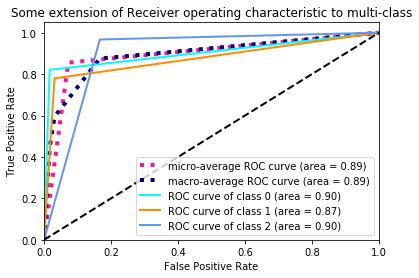

In [305]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [306]:
pdDepth7 = dtpredykcje.toPandas()
lab = label_binarize(pdDepth7['label'].values, classes=[0, 1, 2])
pred = label_binarize(pdDepth7['prediction'].values, classes=[0, 1, 2])
n_classes = lab.shape[1]

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

lab = label_binarize(pdDepth7['label'].values, classes=[0, 1, 2])
pred = label_binarize(pdDepth7['prediction'].values, classes=[0, 1, 2])
n_classes = lab.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(lab[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(roc_auc[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(lab.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

0.917039800995
0.874205508475
0.90820973198


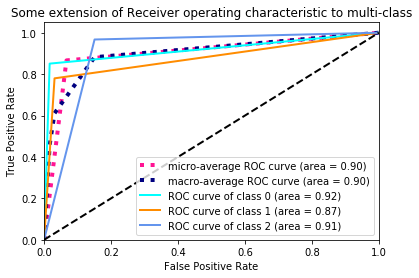

In [310]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
va = Tokenizer(inputCol='Body', outputCol='abc')
#hashingTF oszczędza miejsce i czas przetwarzania (tylko jeden przebieg)
#nie ustalam sztywno ilości cech "numFeatures" - chcę wykorzystać wszystkie słowa
cv = CountVectorizer(inputCol="abc", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

indexer = StringIndexer(inputCol="Tag", outputCol="label")
#lr = LogisticRegression(maxIter=3)
dt = DecisionTreeClassifier()
p = Pipeline(stages=[va,cv,idf,indexer,dt])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.01]) \
    .build()
    
crossval = CrossValidator(estimator=p,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                          numFolds=3) 

ldtModelCV = crossval.fit(train_df)

In [128]:
#.withColumn('wyn', when(dtpredykcje.label == dtpredykcje.prediction,1).otherwise(0)) \

dtpredykcje \
    .groupBy('Tag','label','prediction') \
    .count() \
    .show()

+---------+-----+----------+-----+
|      Tag|label|prediction|count|
+---------+-----+----------+-----+
|   galaxy|  0.0|       2.0|    9|
|telescope|  1.0|       0.0|    1|
|   galaxy|  0.0|       0.0|   55|
|  gravity|  2.0|       2.0|   60|
|   galaxy|  0.0|       1.0|    3|
|telescope|  1.0|       2.0|   13|
|  gravity|  2.0|       0.0|    1|
|telescope|  1.0|       1.0|   45|
+---------+-----+----------+-----+



In [85]:
nb = NaiveBayes(modelType="multinomial")
p = Pipeline(stages=[va,cv,idf,indexer,nb])
nbmodel = p.fit(train_df)
nbpredykcje = nbmodel.transform(test_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(nbpredykcje)
print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g" % accuracy)

Test Error = 0.165775 
Test Accuracy = 0.834225


In [129]:
nbpredykcje \
    .groupBy('Tag','label','prediction') \
    .count() \
    .show()

+---------+-----+----------+-----+
|      Tag|label|prediction|count|
+---------+-----+----------+-----+
|   galaxy|  0.0|       2.0|   16|
|telescope|  1.0|       0.0|    5|
|   galaxy|  0.0|       0.0|   48|
|  gravity|  2.0|       2.0|   55|
|   galaxy|  0.0|       1.0|    3|
|  gravity|  2.0|       1.0|    1|
|telescope|  1.0|       2.0|    1|
|  gravity|  2.0|       0.0|    5|
|telescope|  1.0|       1.0|   53|
+---------+-----+----------+-----+



In [100]:
evaluator2 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator2.evaluate(nbpredykcje)

evaluator3 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
prec = evaluator3.evaluate(nbpredykcje)

evaluator4 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall")
rec = evaluator4.evaluate(nbpredykcje)

print("Test Prec = %g" % prec)
print("Test F1 = %g" % f1)
print("Test Recall = %g" % rec)

Test Prec = 0.839065
Test F1 = 0.833267
Test Recall = 0.834225


In [86]:
rf = RandomForestClassifier()
p = Pipeline(stages=[va,cv,idf,indexer,rf])
rfmodel = p.fit(train_df)
rfpredykcje = rfmodel.transform(test_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(rfpredykcje)
print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g" % accuracy)

Test Error = 0.240642 
Test Accuracy = 0.759358


In [130]:
rfpredykcje \
    .groupBy('Tag','label','prediction') \
    .count() \
    .show()

+---------+-----+----------+-----+
|      Tag|label|prediction|count|
+---------+-----+----------+-----+
|   galaxy|  0.0|       2.0|    6|
|telescope|  1.0|       0.0|   10|
|   galaxy|  0.0|       0.0|   51|
|  gravity|  2.0|       2.0|   45|
|   galaxy|  0.0|       1.0|   10|
|  gravity|  2.0|       1.0|    1|
|telescope|  1.0|       2.0|    3|
|  gravity|  2.0|       0.0|   15|
|telescope|  1.0|       1.0|   46|
+---------+-----+----------+-----+



In [101]:
evaluator2 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator2.evaluate(rfpredykcje)

evaluator3 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
prec = evaluator3.evaluate(rfpredykcje)

evaluator4 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall")
rec = evaluator4.evaluate(rfpredykcje)

print("Test Prec = %g" % prec)
print("Test F1 = %g" % f1)
print("Test Recall = %g" % rec)

Test Prec = 0.766887
Test F1 = 0.761083
Test Recall = 0.759358


In [23]:
# multiclass logistic regresion
va = Tokenizer(inputCol='Body', outputCol='abc')
#t = va.transform(train_df)
hashingTF = HashingTF(inputCol="abc", outputCol="features")
#t = hashingTF.transform(t)
indexer = StringIndexer(inputCol="Tag", outputCol="label")
#t = indexer.fit(t).transform(t)
lr = LogisticRegression(maxIter=3)
#t.printSchema()
p = Pipeline(stages=[va,hashingTF,indexer,lr])
lrmodel = p.fit(train_df)
predykcje = lrmodel.transform(train_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predykcje)
print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g" % accuracy)

Test Error = 0.021978 
Test Accuracy = 0.978022


In [57]:
# multiclass logistic regresion
va = Tokenizer(inputCol='Body', outputCol='abc')
#hashingTF oszczędza miejsce i czas przetwarzania (tylko jeden przebieg)
#nie ustalam sztywno ilości cech "numFeatures" - chcę wykorzystać wszystkie słowa
cv = CountVectorizer(inputCol="abc", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

indexer = StringIndexer(inputCol="Tag", outputCol="label")
lr = LogisticRegression(maxIter=3)
p = Pipeline(stages=[va,cv,idf,indexer,lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.01]) \
    .build()
    
crossval = CrossValidator(estimator=p,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
                          numFolds=2) 

lrModel = crossval.fit(train_df)

#lrmodel = p.fit(train_df)
#predykcje = lrmodel.transform(train_df)

#evaluator = MulticlassClassificationEvaluator(
#    labelCol="label", predictionCol="prediction", metricName="accuracy")

#accuracy = evaluator.evaluate(predykcje)
#print("Test Error = %g " % (1.0 - accuracy))
#print("Test Accuracy = %g" % accuracy)

In [59]:
accuracy = evaluator.evaluate(prediction)
accuracy

0.7488584474885844

In [60]:
evaluator = MulticlassClassificationEvaluator(
   labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(prediction)
print("Test Error = %g " % (1.0 - accuracy))
print("Test Accuracy = %g" % accuracy)

Test Error = 0.251142 
Test Accuracy = 0.748858
